In [1]:
%%capture
!pip install -q kaggle

In [2]:
# Work With Files
from google.cloud import storage
import os

# Useful libraries:
from __future__ import division
from time import time
import numpy as np
import pandas as pd
import re
import json
import math
from functools import reduce

# To Plot:
import matplotlib.pyplot as plt
import seaborn as sns

# Pyspark Lib:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark import SparkContext, SparkConf

# Preprocess:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, StandardScaler

# Pysparl ML:
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
PATH_BUCKET = 'gs://nyc_comp_bk/'
PATH_MAIN = '/home/ubuntu/NYC_Taxi/'

In [4]:
os.chdir(PATH_MAIN)

In [5]:
class Work_On_Bucket():
    
    """
    This class makes possible the connectivity between Jupyter and GClood
    """
    
    def __init__(self, bucket_name):
        
        """
        Here is where the conenction is established, a new variable is created for the connected bucket
        
        Parameters
        ----------
        bucket_name : str
            The name of the Bucket with whom you want to communicate
            
        """
        
        # Get access to the bucket:
        storage_client = storage.Client()
        self.bucket = storage_client.get_bucket(bucket_name)
        
    def get_file_from_bucket(self, file_name, save_path, bucket_folder=''):
        
        """
        
        This function retrieves a file/folder from the connected bucket and save it locally on Jupyter
        
        Parameters
        ----------
        file_name : str
            The name of the file to get from the bucket
        save_path : str
            The path where to save the file on Jupyter
            (ex: /ubuntu/user/my_folder/)
            
        """
        
        # Download the file:
        blob = self.bucket.blob(bucket_folder+file_name)
        blob.download_to_filename(''.join([save_path, file_name]))
            
    def upload_file_to_bucket(self, file_name, folder_path, bucket_folder=''):
        
        """
        This function save a local Jupyter file to the connected Bucket
        
        Parameters
        ----------
        file_name : str
            The name of the file tosave
        folder_path : str
            The path where to find the file on the Bucket
        bucket_folder: str
            the folder where to save file in the Bucket
            
        """
        # Upload the File
        object_to_save = self.bucket.blob(bucket_folder+file_name)
        object_to_save.upload_from_filename(folder_path + file_name)


### Get the Dataset:

In [6]:
Bucket = Work_On_Bucket('nyc_comp_bk')

In [7]:
# Set kaggle:
! mkdir ~/.kaggle
Bucket.get_file_from_bucket('kaggle.json', PATH_MAIN)
! cp /home/ubuntu/NYC_Taxi/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
# Download The Dataset
!kaggle competitions download -c new-york-city-taxi-fare-prediction

# Unzip the Files
! unzip new-york-city-taxi-fare-prediction.zip -d /home/ubuntu/NYC_Taxi/data/
! rm new-york-city-taxi-fare-prediction.zip

# Upload databses to bucket:
print('Start Uploding!')
Bucket.upload_file_to_bucket('train.csv', PATH_MAIN + 'data/')
Bucket.upload_file_to_bucket('test.csv', PATH_MAIN + 'data/')
print('Succesfully Uploaded!')

100%|██████████████████████████████████████▉| 1.56G/1.56G [00:14<00:00, 128MB/s]
100%|███████████████████████████████████████| 1.56G/1.56G [00:14<00:00, 119MB/s]
Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: /home/ubuntu/NYC_Taxi/data/GCP-Coupons-Instructions.rtf  
  inflating: /home/ubuntu/NYC_Taxi/data/sample_submission.csv  
  inflating: /home/ubuntu/NYC_Taxi/data/test.csv  
  inflating: /home/ubuntu/NYC_Taxi/data/train.csv  
Start Uploding!
Succesfully Uploaded!


### Preliminary Steps (Load + Checks):

In [8]:
# Load Data:
data = spark.read.load(PATH_BUCKET+"train.csv", format="csv", inferSchema="true", header="true")
test = spark.read.load(PATH_BUCKET+"test.csv", format="csv", inferSchema="true", header="true")

# Load Test (Because pyspark changes the timestamp):
Bucket.get_file_from_bucket('test.csv', '')
original_test = pd.read_csv('test.csv')

In [9]:
# Get DB shape:
ncol = len(data.columns)
nrow = data.count()
print("The shape of the dataset is {:d} rows by {:d} columns".format(nrow, ncol))

The shape of the dataset is 55423856 rows by 8 columns


In [10]:
# Get the schema:
data.printSchema()

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [9]:
# Remove Key, not needed:
data = data.drop('key')

In [11]:
# Show some basic Statistics:
stats = data.select(data.columns).describe()
stats.toPandas()

,summary,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,count,55423856,55423856,55423856,55423856,55423480,55423480,55423856
1,mean,11.345045601663855,None,-72.50968444358728,39.91979178688818,-72.5112097297181,39.92068144482884,1.6853799201556816
2,stddev,20.7108321982325,None,12.848883381402654,9.642353041994934,12.782196517830771,9.633345796415126,1.327664357095968
3,min,-300.0,2009-01-01 00:00:27 UTC,-3442.059565,-3492.263768,-3442.024565,-3547.886698,0
4,max,93963.36,2015-06-30 23:59:54 UTC,3457.625683,3408.789565,3457.62235,3537.132528,208


In [12]:
# Check Nulls:
for c in data.columns[1:]:
    nans = data.where(col(c).isNull()).count()
    print('{:s}: {:d}'.format(c, nans))

pickup_datetime: 0
pickup_longitude: 0
pickup_latitude: 0
dropoff_longitude: 376
dropoff_latitude: 376
passenger_count: 0


In [10]:
# Remove Rows with Missing Values:
data = data.na.drop(how='any')

In [14]:
# Check Duplicates:
print('The Duplicates are: {:d}'.format(data.count()-data.distinct().count()))

The Duplicates are: 1650


In [11]:
# Remove Duplicates:
data = data.distinct()

### EDA

For the EDA check the dashboard out on the git repository: https://github.com/CalenDario13/NYC_Taxi/blob/main/nyc_comp.twb

#### 1) Latitude and Longitude

From the study of the quantiles it is clear that there are many outlayers, because the NYC coordinates are (lat=40.730610 lon=-73.935242). Even working with quantiles, removing anything out of the I and III quartile things don't change so much. 
Therefore, I opt for anothe option: I draw a triangle around the area of interest and anything outside the triangle will be dropped (because NY City is on an icleand which reminds a triangle). To take into acocunt possible trips from/to the countriside I am using larger bounderies. To decide whether a point is in the selected area I walk clockwise/counterclockwise around the triangle and project the point onto the segment I am crossing by using the dot product. Finally, I check that the vector created is on the same side for each of the triangle's segments.
To have a more permissive approach, it is possible to draw a rectangle and include more points: It seems that there are many taxis that go and come from/to the states placed at the North of NYC. 

There is another issues linked with the coordinates, there are some points (both for pick up and drop off) which are located in the ocean, There are different libraries that can help in removing them, by masking the map, but it takes too much computational resources. Another possibility is to define a more complex shape (instead of a triangle) that defines bounderies more accurately, but this option is too expensive in terms of computation, too (no easy way to compute if a point is in a complex geometric figure). Not having any alternatives I keep them hopping that they won't affect my model too much. 

For what concerns how pick up and drop off locations are distributed in the map, as I expected they are mostly concentrated in Manhattan. Howevere, there are some areas outside it, which seems to have an important tarffic of Taxi: JFK Airport, East Elmhurst, the Newy York Liberty Airport and a point in Hamilton Town in New Jersy. 
It is possible to check that drop off locations are more spread all along NYC and countyside than pickup ones that are more concentrated in Manhattan. Moreover, it seems that the price changes more depending on the dropoff position than the pickup one: the avarage fare amount for a trip seems to increase the further the trip ends outised Mantthan and if a trip starts or stops from/in any NY Airport, checking on the web the routes for the airports have a fixed price (https://www.jfkairport.com/to-from-airport/taxi-car-and-van-service). It is interesting to see how the Fare Amount doesn't depend on the distance from the pickup location for the races towards the airports, instead for the journeys from the airport there is a linear relationship between the distance and the fare amount. For this reason I compute a categorical variable ad hoc, which compute the haversine distance from the airports for both the pickup and dropoff position and if one of them is enough small (enough close) to an airport it shows this with the corresponding label, otherwise it assume that it is a normal trip.

Finally, it seems that some trips are repeted more frequently, the mode is 1, but for some observations the count can arrive up to 36 (and potentially more, for the full dataset). This suggest me that there are some people tha use it regularly, they may get a discount for that reason, a kind of subscription. Given that they are very few, for the moment I am not going to create a variable ad hoc (taking also into account that the data are spread over 6 years, 36 times is not such a significant amount).

At this point, it is possible to compute new features that can be useful both for the model and to remove more outlayers. All the distances are expressed in kilometers. To obtain some of them I need to know how much Kms correspond to the variation of 1 degree for each coordinate and it turns out that for Latitude it is 111 Km and for Longitude is 85 Km; and the radius of the hearth in kilometers (R=6371Km):
 
 - Absolute latitude/longitude Distance:
    <br>
    <br>
    $abs.lat = | Lat_2 - Lat_1 | * 111$
    <br>
    $abs.long = | Long_2 - Long_1 | * 85$
    <br>
    <br>
 - Haversinee Distance:
    <br>
    <br>
    $a = sin^2(\frac{\Delta lat}{2}) + cos(lat_1)*cos(lat_2)*sin^2(\frac{\Delta long}{2})$
    <br>
    $c = 2 * atan2(\sqrt{a},\sqrt{1-a})$
    <br>
    $haverine = R * c$
    <br>
    <br>
 - Manhattan Distance:
    <br>
    <br>
    $manhattan = abs.lat + abs.long$
    <br>
    <br>
 - Euclidean distance:
    <br>
    <br>
    $euclidean = \sqrt{abs.lat^2 + abs.long^2}$
    <br>
    <br>
 - Direction:
    <br>
    <br>
    $y = sin(\Delta long) * cos(lat_2)$
    <br>
    $x = cos(lat_1) * sin(lat_2) - sin(lat_1) * cos(lat_2) * cos(\Delta lon)$
    <br>
    $direction = atan2(y, x)*\frac{180}{\pi}$
    <br>
    
For what concerns the distance metrics, there are a lot of zeros (to which sometimes correspond also high fare amount), these values are probably missing coordinates replaced with zeros or figures wrongly reported. To overcome this issue I am going to drop any row which has the mean between the three compute distances (Euclidean, Manhattan and Haversine) less than 0.500 (namely less than 500 meter). 
The distributions of all the distances are very close each other, they have a mode around 1 Km and they are positive skwed, it is possible to see that the most of the races last aroun 0.5 and 7.0 Kms. 
It is also possible to see a positive relationship between the fare amount and the average kilometers of the journey, the increase in the average of kilometers is more than proportional to the fare amount. To simplify this idea, I create a categorical variable which says whethe a trip is longer or shorter or equal than the average and it seems that my hypothesis is confirmed: the average fare amount for longer trips is far away higher than the one for the shorter trips.
I can then compute the dropoff and pickup distance from Manhatta (lat=40.754932, long=-73.984016), which seems to be the point where the most of taxis start and end their races, using the haverisne distance.
Another feature that can improve my model is the direction (in degree) of the trip. Because the computed distancem is only an approximation and the angle can improve this approximation. To comput the distance I use the Bearing Algorithm and I multiply the result by -1 because of the negative longitude. It doesn't seems to have a direct impact on the average fare amount, but maybe (expecially in a linear model) I can multiply this variable with the distances to reduce the loss function.

In [12]:
# Check I, II and III Quantiles:
np.array([data.approxQuantile('pickup_longitude', [0.25, 0.50, 0.75], 0.25),
          data.approxQuantile('pickup_latitude', [0.25, 0.50, 0.75], 0.25),
          data.approxQuantile('dropoff_longitude', [0.25, 0.50, 0.75], 0.25),
          data.approxQuantile('dropoff_latitude', [0.25, 0.50, 0.75], 0.25)])

array([[-3442.059565,  2123.82246 ,  3457.625683],
       [-3492.263768,   444.133332,  3408.789565],
       [-3442.024565,   -73.980088,  3457.62235 ],
       [-3547.886698,  2599.28739 ,  3537.132528]])

In [12]:
# Write function to check if a point is a triangle:

def point_in_triangle(lat, long):
    
    """
    phuclv (https://stackoverflow.com/questions/2049582/how-to-determine-if-a-point-is-in-a-2d-triangle)
    To decide whether a point is in the triangle walk clockwise or counterclockwise around the triangle and 
    project the point onto the segment crossing by using the dot product. 
    Finally, check that the vector created is on the same side for each of the triangle's segments.
    
    Parameters
    ----------
    lat : float
        The latitude coordinate of a point
    long :float
        The longitude oordinate of a point

    Returns
    -------
    bool
        whether all signs of the sides are positive/negative
        
    """
    
    # Unpack arguments
    x = lat
    y = long
    ax, ay = (39.74274655286439, -75.26399018397262)
    bx, by = (41.58840050439113, -75.18708588709761)
    cx, cy = (41.07279488244855, -71.76484467616011)
    # Segment A to B
    side_1 = (x - bx) * (ay - by) - (ax - bx) * (y - by)
    # Segment B to C
    side_2 = (x - cx) * (by - cy) - (bx - cx) * (y - cy)
    # Segment C to A
    side_3 = (x - ax) * (cy - ay) - (cx - ax) * (y - ay)
    # All the signs must be positive or all negative
    return (side_1 < 0.0) == (side_2 < 0.0) == (side_3 < 0.0)

def is_in_area(lat1, lon1, lat2, lon2):
    
    """
    
    Check whether both pick up and drop off points of an observation
    are in the triangle.
    
    Parameters
    ----------
    lat1 : float
        The latitude coordinate of a pick up point
    long1 :float
        The longitude oordinate of a pick up point
        
    lat2 : float
        The latitude coordinate of a drop off point
    long2 :float
        The longitude oordinate of a drop off point

    Returns
    -------
    bool
        whether both the points are in the hotspot
        
    """
    
    pick = point_in_triangle(lat1, lon1)
    drop = point_in_triangle(lat2, lon2)
    
    return all([pick, drop])

is_in_area_udf = F.udf(is_in_area, BooleanType())

In [13]:
# Remove any point outside the given area:
data = data.withColumn('keep', is_in_area_udf( col('pickup_latitude'), col('pickup_longitude'), col('dropoff_latitude'), col('dropoff_longitude') ))
data = data.filter("keep == True")
data = data.drop('keep')

In [15]:
data.select(col('pickup_latitude'), col('pickup_longitude'), col('dropoff_latitude'), col('dropoff_longitude')).describe().show()

+-------+--------------------+-------------------+-------------------+--------------------+
|summary|     pickup_latitude|   pickup_longitude|   dropoff_latitude|   dropoff_longitude|
+-------+--------------------+-------------------+-------------------+--------------------+
|  count|            54235168|           54235168|           54235168|            54235168|
|   mean|   40.75084046363401| -73.97546359704323|  40.75123945667267|  -73.97456012998938|
| stddev|0.027549044484391723|0.03574727580738844|0.03143901853685563|0.035618188092662054|
|    min|           39.804188| -75.25401306152344|           39.80016|  -75.25403594970703|
|    max|           41.519495|           -72.0619|          41.567147|           -71.97642|
+-------+--------------------+-------------------+-------------------+--------------------+



In [14]:
# Write Functions needed to Create Coordinates Features

class Coordinates_Transform():
    
    """
    
    This class allows to create new features exploting the latitude and longitude of the pickup and dropoff position
    
    Parameters
        ----------
        df : Pyspark Database
            The database to use to make the transformations

    """

    def __init__(self, df):

        self.df = df
        self.haversine_udf = F.udf(Coordinates_Transform.haversine_stat, DoubleType())
        self.direction_udf = F.udf(Coordinates_Transform.calculate_dir, DoubleType())
        self.airports_udf = F.udf(Coordinates_Transform.identify_airports, StringType())


    @staticmethod
    def haversine_stat(pick_lat, drop_lat, pick_long, drop_long):
        
        """

        Compute the Haversine Distance

        Parameters
        ----------
        pick_lat : float
            The latitude coordinate of a pick up point
        pick_long :float
            The longitude oordinate of a pick up point

        drop_lat : float
            The latitude coordinate of a drop off point
        drop_long :float
            The longitude oordinate of a drop off point

        Returns
        -------
        float
            The Haversine Distance between the pick up point and the drop off one

        """
        
        # Transform in radians the coordinate:
        longit_a, latit_a, longit_b, latit_b = map(math.radians, [pick_long,  pick_lat, drop_long, drop_lat])
        
        # Compute the delta between both the coordinates:
        dist_longit = longit_b - longit_a
        dist_latit = latit_b - latit_a
        
        # Calculate area
        area = math.sin(dist_latit/2)**2 + math.cos(latit_a) * math.cos(latit_b) * math.sin(dist_longit/2)**2
        # Calculate the central angle
        central_angle = 2 * math.asin(math.sqrt(area))

        # Calculate Distance
        RADIUS = 6371
        distance = central_angle * RADIUS
        return round(distance, 3)

    def add_dist_metrics(self):
        
        """

        Compute Some distance metrics, such as: 
            - Absolute Distance 
            - Manahattan Distance
            - Euclidean Distance 
            - Haversine Distance.

        Returns
        -------
        Spark Database
            A Spark Databse containing the new features

        """
       
        # Absolute Lat e Long Distance:
        self.df = self.df.withColumn( 'abs_dist_longitude', F.round( F.abs( col('pickup_longitude') - col('dropoff_longitude') ) * 85, 3 ) )
        self.df = self.df.withColumn( 'abs_dist_latitude', F.round( F.abs( col('pickup_latitude') - col('dropoff_latitude') ) * 111 , 3 ) )

        # Manhattan Distance:
        self.df = self.df.withColumn( 'manhattan_dist', F.round( col('abs_dist_longitude') + col('abs_dist_latitude'), 3 ) )

        # Euclidean Distance:
        self.df = self.df.withColumn( 'euclidean_dist',  F.round( F.sqrt( col('abs_dist_longitude')**2 + col('abs_dist_latitude')**2 ), 3 ) )

        # Haversine Distance:
        self.df = self.df.withColumn( 'haversine_dist', 
                                     self.haversine_udf( col('pickup_latitude'), col('dropoff_latitude'), col('pickup_longitude'), col('dropoff_longitude') ) ) 

        return self.df
    
    def distance_from_center(self):
        
        """

        It computes the haversine distance for both pickup and dropoff position from the city center
        which I choose to be Manhattan.

        Returns
        -------
        Spark Databse
            A database containing all the older variables plus the new one

        """
        
        MANHATTAN_LAT = F.lit(40.754932)
        MANHATTAN_LON = F.lit(-73.984016)
        
        self.df = self.df.withColumn( 'pickup_from_center', 
                                     self.haversine_udf( MANHATTAN_LAT, col('pickup_latitude'), MANHATTAN_LON, col('pickup_longitude') ) )
        self.df = self.df.withColumn( 'dropoff_from_center', 
                                     self.haversine_udf( MANHATTAN_LAT, col('dropoff_latitude'), MANHATTAN_LON, col('dropoff_longitude') ) )

        return self.df
        

    @staticmethod
    def calculate_dir(lat1, lon1, lat2, lon2):

        '''
        
        https://www.movable-type.co.uk/scripts/latlong.html
        It is measured in 0 - 360 degrees
        
        Parameters
        ----------
        lat1 : float
            The latitude coordinate of a pick up point
        lon1 :float
            The longitude oordinate of a pick up point

        lat : float
            The latitude coordinate of a drop off point
        lon2 :float
            The longitude oordinate of a drop off point

        Returns
        -------
        float
            The computed degree between 0 and 360
        
        '''

        dlon = lon2 - lon1
        y = math.sin(dlon) * math.cos(lat2)
        x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
        theta = math.atan2(y, x)*180/math.pi

        return (-theta + 360) % 360



    def direction(self):
        
        '''
        
        It executes the function to compute the degree on the database of the clas

        Returns
        -------
        Spark Databse
            A database containing all the older variables plus the new one
        
        '''
        
        self.df = self.df.withColumn('direction', self.direction_udf( col('pickup_latitude'), col('pickup_longitude'), col('dropoff_latitude'), col('dropoff_longitude') ))
        return self.df

    def third_dim_remap(self):
        
        '''
        The credit for the next features goes to Jan van der Vegt @datascience.stackexchange.com
        https://datascience.stackexchange.com/users/14904/jan-van-der-vegt
        
        It recomputes the coordinates in 3D. It is useful to be more precise and when I am going to work with trees based models.
        
        Returns
        -------
        Spark Databse
            A database containing all the older variables plus the new one
            
        '''
        # Compute coordinates for pickup:
        self.df = self.df.withColumn('pickup_x', F.cos('pickup_latitude') * F.cos('pickup_longitude'))
        self.df = self.df.withColumn('pickup_y', F.cos('pickup_latitude') * F.sin('pickup_longitude'))
        self.df = self.df.withColumn('pickup_z', F.sin('pickup_latitude'))

        # Compute coordinates for dropoff
        self.df = self.df.withColumn('dropoff_x', F.cos('dropoff_latitude') * F.cos('dropoff_longitude'))
        self.df = self.df.withColumn('dropoff_y', F.cos('dropoff_latitude') * F.sin('dropoff_longitude'))
        self.df = self.df.withColumn('dropoff_z', F.sin('dropoff_latitude'))

        return self.df


    @staticmethod
    def identify_airports(pick_lat, drop_lat, pick_long, drop_long):
        
        '''
        
        This function identifies whether a journey starts or ends near by an airport,
        It computes the haversine distance both for the pickup position and dropoof position
        and the airports, if the distance is lower than 2 Kms it assigns the corresponding label.
        
        Parameters
        ----------
        pick_lat : float
            The latitude coordinate of a pick up point
        pick_long :float
            The longitude oordinate of a pick up point

        drop_lat : float
            The latitude coordinate of a drop off point
        drop_long :float
            The longitude oordinate of a drop off point

        Returns
        -------
        str
            label to identify if a trip is started/ended at the airports
        
        '''

        # Set the coordinates of airports:
        JFK_LAT = 40.641766
        JFK_LON = -73.780968

        LGR_LAT = 40.773013
        LGR_LON = -73.870229

        EWR_LAT = 40.689531
        EWR_LON = -74.174462

        # Compute distances:
        pick_up_jfk = Coordinates_Transform.haversine_stat(JFK_LAT, pick_lat, JFK_LON, pick_long)
        drop_off_jfk = Coordinates_Transform.haversine_stat(drop_lat, JFK_LAT, drop_long, JFK_LON)

        pick_up_lgr = Coordinates_Transform.haversine_stat(LGR_LAT, pick_lat, LGR_LON, pick_long)
        drop_off_lgr = Coordinates_Transform.haversine_stat(drop_lat, LGR_LAT, drop_long, LGR_LON)

        pick_up_ewr = Coordinates_Transform.haversine_stat(EWR_LAT, pick_lat, EWR_LON, pick_long)
        drop_off_ewr = Coordinates_Transform.haversine_stat(drop_lat, EWR_LAT, drop_long, EWR_LON)

        print(pick_up_jfk, drop_off_jfk)
        # Assign a value:
        if pick_up_jfk < 2:
            return 'PICK_JFK'
        elif drop_off_jfk < 2:
            return 'DROP_JFK'
        if pick_up_lgr < 2:
            return 'PICK_LGR'
        elif drop_off_lgr < 2:
            return 'DROP_LGR'
        if pick_up_ewr < 2:
            return 'PICK_EWR'
        elif drop_off_ewr < 2:
            return 'DROP_EWR'
        else:
            return 'NO_AIRPORT'

    def airports(self):
        
        '''
        It executes the function to identify trips started/ended near by the airports
        
        Returns
        -------
        Spark Databse
            A database containing all the older variables plus the new one
            
        '''

        self.df = self.df.withColumn('airport', 
                                     self.airports_udf( col('pickup_latitude'), col('dropoff_latitude'), col('pickup_longitude'), col('dropoff_longitude') ))
        return self.df

    def long_short_trip(self):
        
        '''
        It identifies whether a trip is longer or shorter than the avergare haversine distance.
        Possible improvments: use the mode or a value picked ad hoc from the distribution such as 7
        (the second improvment is also in terms of speed of computation).
        
        Returns
        -------
        Spark Databse
            A database containing all the older variables plus the new one
            
        '''

        mean_len = self.df.select('haversine_dist').agg(F.mean(col('haversine_dist'))).first()[0]
        self.df = self.df.withColumn( 'long_short', F.when(col('haversine_dist') <= mean_len, 'short') \
                                     .otherwise('long') )
        return self.df



In [15]:
# Add Distance metrics:
coordTransform = Coordinates_Transform(data)
data = coordTransform.add_dist_metrics()

In [18]:
# Let's Check df:
data.select('abs_dist_longitude', 'abs_dist_latitude', 'manhattan_dist', 'euclidean_dist', 'haversine_dist').describe().toPandas()

,summary,abs_dist_longitude,abs_dist_latitude,manhattan_dist,euclidean_dist,haversine_dist
0,count,54235168,54235168,54235168,54235168,54235168
1,mean,1.9286066518499425,2.357046155476089,4.28565280732606,3.3246101278786595,3.315646530605393
2,stddev,2.887787858818069,2.5609968462258927,4.783709562936858,3.6221773285676875,3.607593005204814
3,min,0.0,0.0,0.0,0.0,0.0
4,max,158.809,128.346,210.365,163.92,162.283


In [16]:
# Let's remove outlayers:
DIST_METRICS = ['manhattan_dist', 'euclidean_dist', 'haversine_dist']
n = len(DIST_METRICS)
row_mean  = (sum(col(x) for x in DIST_METRICS) / n).alias("mean_dist")
data = data.where( (row_mean >= 0.5) )

In [20]:
data.select('abs_dist_longitude', 'abs_dist_latitude', 'manhattan_dist', 'euclidean_dist', 'haversine_dist').describe().toPandas()

,summary,abs_dist_longitude,abs_dist_latitude,manhattan_dist,euclidean_dist,haversine_dist
0,count,52277799,52277799,52277799,52277799,52277799
1,mean,1.9966080829072308,2.4408030829874807,4.437411165894727,3.4421882540617297,3.4329118362653372
2,stddev,2.919377212362032,2.5708288215629684,4.806322907125751,3.636923794344817,3.6221358994083372
3,min,0.0,0.0,0.5,0.44,0.438
4,max,158.809,128.346,210.365,163.92,162.283


In [17]:
# Add Directions:
data = coordTransform.direction()

In [18]:
# Add third dimension:
data = coordTransform.third_dim_remap()

In [19]:
# Let's Add when starting point or arrival is at the airport:
data = coordTransform.airports()

In [ ]:
# Check avg price for the airports:
data.select('airport','fare_amount').groupBy('airport').agg(F.mean('fare_amount'), F.stddev('fare_amount'), F.count('fare_amount')).sort('avg(fare_amount)').show()

+----------+------------------+------------------------+------------------+
|   airport|  avg(fare_amount)|stddev_samp(fare_amount)|count(fare_amount)|
+----------+------------------+------------------------+------------------+
|NO_AIRPORT| 9.805857909599204|      20.095290311293294|          51245784|
|  PICK_LGR| 30.31977970052851|      11.499853431533305|           1099004|
|  DROP_LGR|30.947311994375728|       7.715635313183146|            671323|
|  PICK_JFK|43.932558035713896|      16.581543542956524|            810880|
|  DROP_JFK| 50.35574337028614|       8.367285405592215|            337194|
|  PICK_EWR|60.988619949248466|      36.609269575459976|              5123|
|  DROP_EWR|  70.9053423929548|      14.149131512730918|             65860|
+----------+------------------+------------------------+------------------+



In [20]:
# Add Pickup and Dropoff distance from the city center:
data = coordTransform.distance_from_center()

In [30]:
data.select("pickup_from_center", "dropoff_from_center", "fare_amount").show(5)

+------------------+-------------------+-----------+
|pickup_from_center|dropoff_from_center|fare_amount|
+------------------+-------------------+-----------+
|             1.407|              2.707|       11.0|
|              1.32|               1.35|        5.5|
|             0.496|               2.34|        8.1|
|             0.802|              4.085|       12.5|
|             5.746|              2.029|       14.9|
+------------------+-------------------+-----------+
only showing top 5 rows



In [21]:
# Add a binning for the length, based on the haversine distance:
data = coordTransform.long_short_trip()

In [26]:
# Check avg price for binned trip length:
data.select('long_short' ,'fare_amount').groupBy('long_short').agg(F.mean('fare_amount'), F.stddev('fare_amount'), F.count('fare_amount')).show()

+----------+-----------------+------------------------+------------------+
|long_short| avg(fare_amount)|stddev_samp(fare_amount)|count(fare_amount)|
+----------+-----------------+------------------------+------------------+
|      long|19.82420825373721|      22.274972965933255|          16769255|
|     short| 7.52029804345085|      18.959355627956782|          37465913|
+----------+-----------------+------------------------+------------------+



#### 2) Time Variables:

From the pickup_datetime column it is possible to extract some information about the time at which the race happened, such as:

    - Year
    - Quarter
    - Month
    - Week of year
    - Day of Month
    - Day of Week
    - Day of Year
    - Hour
    - Minutes
    - Seconds
    
Without going further, it is already possible to extract some useful information from this data. The average Fare amount for a race have been increased during the years, in particular from 2011 to 2013 it had grew by 2 dollars. 
The Fare Amount during the year has an increasing trend: it has its bottom in January, then increases till May - June, then it has drop in July-August and then it grows again in September and stays stable till the end of the year. This trend is confirmed by the anlysis of quarters, which highlights how the second one has the highest average fare amount and also the highest frequency. This trend can be justified by the increase of the number of travelling people in that period. In support of my thesis, if I keep only the trips from/to the airports, the max number of races are in the second quarter, this highlights that in that period more poeple travel. Anyway, also the frequency of the races inside the city grows in that perios, so I can suppose that more poeple are in the city during that period. 
Even if the first month of year seems to be the one with the lowest Fare Amount, the first week of the year is an exception, it has the third highest average fare amoutn, it is probable due to the New Year Eves.
Finally, it is possible to check that the average fare amount is very high during the night, expecially at 5am. But it is not a real increase in the price, it happens because the trips are longer on average at the time, I can suppose that this races bring people home after parties or to work during the morining. In particular, seems that at that time there is a hsotpot in the JFK airport, many people are picked up from there. Instead the average fare per kilometer (namely an increase of the price for each kilometer done) happens later: from 8am to 4pm, the fare amount is the highest.

Checking on the web (https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page) i have found that at different part of the day, there price for a race can chaneg due to the fact to different fees to pay. For this purpose I have created a categorical variable ad hoc, which divides the day in 5 parts (morning, afternoon, rush hour, evening and overnight). The most of the races happen overnight and during the morining, but it seems that the average fare amount is stable during the whole day. 
It is also interesting to check whether the average fare amount changes during the weekend, also in this case the answer is negative, but I can say that the most of the races happen during the working days (Mon - Fri).

Even if DateTime features are cyclical variables, when I extract them I loose this kind of information, I just have an ascending order of data points. To take into account this information I can make some transformatiosn to my data using two different periodic functions:

<center>
<br>
    
$xsin = sin(\frac{2\pi x}{max(x)})$
    
<br>
    
$xcos = cos(\frac{2\pi x}{max(x)})$
    
<br>
</center>

<br>
    
However, this approach doesn't work well for decision trees based algorithms (Random Forest, Gradient Boosted Trees, XGBoost) which build their split rules according to one feature at a time. An alternative way to transform date time features in continious way and in some way to catch the cycle, it is possible to opt for the fraction of the day/week/year/... . These variables have the advantage to work well with the non-linear models. These features can be easily computed as the sum of all the components of that datetime feature converted to the same unit, for example the fraction of the day is expressed in hours and is:

<center>

    
$fracOfDay = hour + \frac{minutes}{60} + \frac{seconds}{3600}$

<br>
<br>
</center>


In [22]:
class Time_Transform():
    
    """
    
    This class extracts any interesting time features from the the pickup_datetime
    
    Parameters
        ----------
        df : Pyspark Database
            The database to use to make the transformations
        
    """

    def __init__(self, df):
        
        """
        
        Takes in input the databse to use and transformm the column pickup_datetime
        in the DateTime format to extract what I need
        
        """

        self.df = df.withColumn('pickup_datetime', F.substring(col('pickup_datetime'), 1, 19))\
        .withColumn('pickup_datetime', F.to_timestamp(col('pickup_datetime')))
        

    def get_date(self, remove_original=False):
        
        '''
        
        It extracts all the basics information from the the datime,
        (such as: year, month, day of the week, day of the year, ...)
       
       Parameters
        ----------
        
        remove_original : bool
            if True it removes the pickup_datetime column

        Returns
        -------
        Spark Databse
            the old databse with the new variables
        
        '''

        self.df = self.df.withColumn('year', F.year(col('pickup_datetime'))) \
        .withColumn('month', F.month(col('pickup_datetime'))) \
        .withColumn('week_of_year', F.weekofyear(col('pickup_datetime'))) \
        .withColumn('quarter', F.quarter(col('pickup_datetime')))\
        .withColumn('day_of_month', F.dayofmonth(col('pickup_datetime'))) \
        .withColumn('day_of_week', F.dayofweek(col('pickup_datetime'))) \
        .withColumn('day_of_year', F.dayofyear(col('pickup_datetime'))) \
        .withColumn('hour', F.hour(col('pickup_datetime'))) \
        .withColumn('minute', F.minute(col('pickup_datetime'))) \
        .withColumn('second', F.second(col('pickup_datetime')))

        if remove_original:
            self.df = self.df.drop('pickup_datetime')

        return self.df

    def is_weekend(self):
        
        '''
        
        It creates a new column which identifaies whether the trip was in the weekend or not
        

        Returns
        -------
        Spark Database
            the old databse with the new variable
        
        '''

        self.df = self.df.withColumn('is_week_end', F.when( (col('day_of_week')==6) | (col('day_of_week')==7), 'True' )\
                                    .otherwise('False'))
        return self.df


    def divide_day(self):
        
        '''
        
        It creates a new column which identifaies in which part of the day the trip was done.
        

        Returns
        -------
        Spark Database
            the old databse with the new variable
        
        '''

        self.df = self.df.withColumn('part_of_day', F.when(col('hour')>=20, 'overnight')\
                                     .when((col('hour')>=0) & (col('hour')<=6), 'overnight')\
                                     .when((col('hour')>6) & (col('hour')<=12), 'morning')\
                                     .when((col('hour')>12) & (col('hour')<16), 'afternoon')\
                                     .when((col('hour')>=16) & (col('hour')<20) & (col('is_week_end')=='False'), 'rush_hour')\
                                     .when((col('hour')>=16) & (col('hour')<20) & (col('is_week_end')=='True'), 'evening'))

        return self.df


    def add_fractions(self, remove_original=False, remove_cat=False):
        
        '''
        
        It transforms some of the DateTime vatiables from Discrete to Continious using the idea of fraction of the whole.
        Ex. frac_of_day identifies in which fraction of day the race occurs: ( (race.hour + race.minute/60 + race.second/3600) / tot.hour )
        
        This approach works well in practice with non-linear models.
       
       Parameters
        ----------
        
        remove_original : bool
            if True it removes the pickup_datetime column
        remove_cat : bool
            if True it removes all the original variables extracted from pickup_datetime

        Returns
        -------
        Spark Databse
            the old databse with the new variables
        
        '''

        self.df = self.df.withColumn('frac_of_day', ( col('hour') + col('minute')/60 + col('second')/3600 )/24 )\
        .withColumn('frac_of_week',  (col('day_of_week') + col('frac_of_day') )/7) \
        .withColumn('frac_of_month', ( col('day_of_month') + col('frac_of_day') ) / ( F.dayofmonth(F.last_day( col('pickup_datetime') ))+1 ) )\
        .withColumn('frac_of_year', ( col('day_of_year') + col('frac_of_day') )/(365 + 1) )     

        if remove_original:
            self.df = self.df.drop('pickup_datetime')
        if remove_cat:
            self.df = self.df.drop('month', 'week_of_year', 'quarter', 'day_of_month', 'day_of_week', 'day_of_year', 'hour',
                                   'minute', 'second')
        return self.df

    def cyclical_encoding(self, remove_original=False, remove_cat=False):
        
        '''
        
        https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
        https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
        A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.
        We can do that using the following transformations:

        xsin=sin(2∗π∗x/max(x)) 
        xcos=cos(2∗π∗x/max(x))
        
        It is useful to transform discrete variables in continious ones. This encoding can be useful when work with linear model.
        (DON'T USE FOR NON LINEAR MODEL SUCH AS RANDOM FOREST AND DECISION TREES!)
        
        Parameters
        ----------
        
        remove_original : bool
            if True it removes the pickup_datetime column
        remove_cat : bool
            if True it removes all the original variables extracted from pickup_datetime

        Returns
        -------
        Spark Databse
            the old databse with the new variables
        
        '''

        self.df = self.df.withColumn('month_sin', F.sin(col('month') * 2*math.pi / 12))\
        .withColumn('month_cos', F.cos(col('month') * 2*math.pi / 12))\
        .withColumn('week_of_year_sin', F.sin(col('week_of_year') * 2*math.pi / 52))\
        .withColumn('week_of_year_cos', F.cos(col('week_of_year') * 2*math.pi / 52))\
        .withColumn('quarter_sin', F.sin(col('quarter') * 2*math.pi / 4))\
        .withColumn('quarter_cos', F.cos(col('quarter') * 2*math.pi / 4))\
        .withColumn('day_of_month_sin', F.sin(col('day_of_month') * 2*math.pi / 31))\
        .withColumn('day_of_month_cos', F.cos(col('day_of_month') * 2*math.pi / 31))\
        .withColumn('day_of_week_sin', F.sin(col('day_of_week') * 2*math.pi / 7))\
        .withColumn('day_of_week_cos', F.cos(col('day_of_week') * 2*math.pi / 7))\
        .withColumn('day_of_yearh_sin', F.sin(col('day_of_year') * 2*math.pi / 366))\
        .withColumn('day_of_year_cos', F.cos(col('day_of_year' ) * 2*math.pi / 366))\
        .withColumn('hour_sin', F.sin(col('hour') * 2*math.pi / 24))\
        .withColumn('hour_cos', F.cos(col('hour') * 2*math.pi / 24))\
        .withColumn('minute_sin', F.sin(col('minute') * 2*math.pi / 60))\
        .withColumn('minute_cos', F.cos(col('minute') * 2*math.pi / 60))

        if remove_original:
            self.df = self.df.drop('pickup_datetime')
        if remove_cat:
            self.df = self.df.drop('month', 'week_of_year', 'quarter', 'day_of_month', 'day_of_week', 'day_of_year', 'hour',
                                   'minute', 'second')

        return self.df


In [23]:
# Get daates basic info:
timeTransform = Time_Transform(data)
data = timeTransform.get_date()

In [29]:
data.select('pickup_datetime','year','month', 'week_of_year', 'quarter','day_of_month', 'day_of_week','day_of_year','hour','minute','second').show(5)

+-------------------+----+-----+------------+-------+------------+-----------+-----------+----+------+------+
|    pickup_datetime|year|month|week_of_year|quarter|day_of_month|day_of_week|day_of_year|hour|minute|second|
+-------------------+----+-----+------------+-------+------------+-----------+-----------+----+------+------+
|2013-02-25 12:53:52|2013|    2|           9|      1|          25|          2|         56|  12|    53|    52|
|2013-03-10 12:22:39|2013|    3|          10|      1|          10|          1|         69|  12|    22|    39|
|2012-05-04 13:33:00|2012|    5|          18|      2|           4|          6|        125|  13|    33|     0|
|2010-08-12 14:27:00|2010|    8|          32|      3|          12|          5|        224|  14|    27|     0|
|2010-05-21 18:57:00|2010|    5|          20|      2|          21|          6|        141|  18|    57|     0|
+-------------------+----+-----+------------+-------+------------+-----------+-----------+----+------+------+
only showi

In [24]:
# Check if it is weekend:
data = timeTransform.is_weekend()

In [31]:
data.select('is_week_end', 'fare_amount').groupby('is_week_end').agg(F.mean('fare_amount')).show()

+-----------+------------------+
|is_week_end|  avg(fare_amount)|
+-----------+------------------+
|      False|11.385143825938746|
|       True|11.187080945739638|
+-----------+------------------+



In [25]:
# Check part of the day:
data = timeTransform.divide_day()

In [33]:
data.select('part_of_day', 'fare_amount').groupby('part_of_day').agg(F.mean('fare_amount')).show()

+-----------+------------------+
|part_of_day|  avg(fare_amount)|
+-----------+------------------+
|  afternoon|11.768674577986591|
|  overnight|11.508201533693835|
|  rush_hour|11.170062041233122|
|    morning|10.992560077359562|
|    evening|10.994244561142468|
+-----------+------------------+



In [26]:
# Transform Time to be used better in the models:
data = timeTransform.add_fractions()
data = timeTransform.cyclical_encoding(remove_cat=False, remove_original=True)

#### 3) Passenger count:

As the NYC Taxi web site reports:* "The maximum amount of passengers allowed in a yellow taxicab by law is four in a four passenger taxicab or five passengers in a five passenger taxicab, except that an additional passenger must be accepted if such passenger is under the age of seven and is held on the lap of an adult passenger seated in the rear. So I remove everything below zero and higher than 5. But I must keep into acocunt also the Van service, which from/to the airport can bring up to 15 pople, even if it is an extreme case (I may consider it as an outlayer let's see later on), for the moment I am going to keep up to 15 seats. It seems good to have kept also higher number of passenger, as matter of fact for a number of seats higher than 6 the average fare amount increases. I can also observe that there is lack for number of seats between 10 and 15. It seems that for a normal trip in a yellow taxi the fare amount is almost the same, instead for vans it positively increases with the number of passengers.
To take into account this difference between Taxi and van I am goign to create an ad hoc variable.

In [35]:
# Check my data:
data.select('passenger_count').describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          54235168|
|   mean| 1.685401693602203|
| stddev|1.3154630695998806|
|    min|                 0|
|    max|               208|
+-------+------------------+



In [27]:
# Clean Train:
data = data.filter('passenger_count > 0 AND passenger_count <=15')

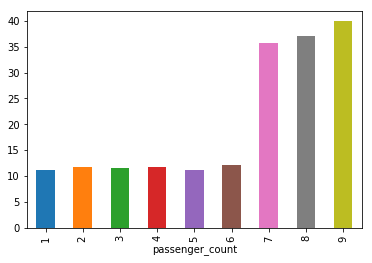

In [37]:
data.select('passenger_count', 'fare_amount').groupby('passenger_count').agg(F.mean('fare_amount')).sort('passenger_count')\
.toPandas().plot.bar('passenger_count', 'avg(fare_amount)',legend=False)
plt.show()

In [28]:
# FInd whch is a taxi and whoch a van
def taxi_or_van(df):
    
    '''
        
    Dependning on the number of seats choose if the veicle is a taxi or a van if seats > 5 than Van.


    Parameters
    ----------

    df : Spark Database
        a spark database containg the columns I need
    Returns
    -------
    Spark Databse
        the old databse with the new variables
        
    '''
    
    df = df.withColumn('taxi_or_van', F.when( (col('passenger_count') <= 6), 'taxi')\
                      .otherwise('van'))
    return df

In [29]:
# Add taxi vs van variable to df:

data = taxi_or_van(data)

#### 4) Fare Amount

Checking the statistics, it is clear that some values are not possible, I am going to remove negatives values and all values that are lower that 2.50 dollars (https://nymag.com/nymetro/urban/features/taxi/n_20286/). Hence, I will keep all values greather than 2.50 dollars. For what concerns the maximum it is difficult to think about a joutney in taxi for a price of 93963 dollars. The median instead is around 325 dollars, which is a more reasonable value. It is clear that the distribution is right skewed (mean < median) and in addition the values over the median are only 134 and looking for some of their attributes it seems that there is no real reasons to have so huge fare amount. Given that I suppose that the most of them are outlayers, therefore I am going to drop anything over the median. Furthermore, considering the high skew, it may be reasonable to drop somenthing more, too. As matter of fact, the distribution clearly shows that values over 100 dollars are very few (almost 20 thousands, the 0.03% of the total). Hence, even if some of them can be reasonable, I am going to drop anything less than 100 dollars. In a second moment it is possible to add again those values to check whether it is possible to improve the model we some special cases.


In [40]:
# Get statistics:
data.select('fare_amount').describe().toPandas()

,summary,fare_amount
0,count,54044321
1,mean,11.33294135419023
2,stddev,20.86706348406584
3,min,-300.0
4,max,93963.36


In [30]:
# Remove Values lower than 2.50$:
data = data.filter('fare_amount > 2.50')

In [47]:
# Compute Quantiles:
fair_quantiles= data.approxQuantile('fare_amount', [0.25, 0.50, 0.75], 0.25)
fair_quantiles

[2.51, 375.0, 93963.36]

In [56]:
# Check some values over the median
print('Obs over the median: {:d}'.format(data.filter('fare_amount > 375').count()))
data.filter('fare_amount>375').select('fare_amount','haversine_dist', 'direction','airport','passenger_count','taxi_or_van').show(10)

Obs over the median: 134
+-----------+--------------+------------------+----------+---------------+-----------+
|fare_amount|haversine_dist|         direction|   airport|passenger_count|taxi_or_van|
+-----------+--------------+------------------+----------+---------------+-----------+
|      400.0|           0.0|             180.0|NO_AIRPORT|              1|       taxi|
|      499.0|         0.012|324.26197795325294|NO_AIRPORT|              1|       taxi|
|      475.0|         0.001|             180.0|NO_AIRPORT|              1|       taxi|
|      450.0|         0.001| 4.396683387821781|NO_AIRPORT|              1|       taxi|
|     377.75|        84.095| 52.57840168530231|  PICK_LGR|              1|       taxi|
|      440.0|           0.0| 44.98473111992348|NO_AIRPORT|              1|       taxi|
|     444.44|           0.0| 90.00000821723745|NO_AIRPORT|              1|       taxi|
|      400.0|           0.0|               0.0|NO_AIRPORT|              1|       taxi|
|      450.0|     

In [65]:
# Percentage of rows with fare amount over 100:
print("Percentage of obs wit fare over 100$: {}" .format(data.filter('fare_amount >= 100').agg(F.count('fare_amount')).toPandas().iloc[0,0] / data.count() * 100) )

Percentage of obs wit fare over 100$: 0.0367605463991


In [31]:
# Remove Outlayers:
data = data.filter('fare_amount < 100')

In [32]:
# Round to the third decimal:
data = data.withColumn('fare_amount', F.round('fare_amount', 3))

### Save DF for Tableau:

In [ ]:
# Save new df for the dashboard:
'''
print('Start Create Csv:')
s = time()
to_csv = data.select('fare_amount','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', 'pickup_from_center', 'dropoff_from_center',
'haversine_dist', 'direction', 'airport', 'long_short', 'passenger_count', 'taxi_or_van','is_week_end','part_of_day')
to_csv = to_csv.sample(fraction=0.02, seed=123)
to_csv.coalesce(1).write.format("csv").option('header', 'true').save(PATH_BUCKET+'new_train')
print('End creation in {:.2f} minutess'.format( (time()-s)/60 ))
'''

Start Create Csv:


### Split Train and Validation:

In [33]:
train, validation = data.randomSplit(weights=[0.9999, 0.0001], seed=123)

### Transform Test:

In [34]:
coordTransformTest = Coordinates_Transform(test)
timeTransformTest = Time_Transform(test)
# Add Distance metrics:
test = coordTransformTest.add_dist_metrics()
# Add Directions:
test = coordTransformTest.direction()
# Add third dimension:
test = coordTransformTest.third_dim_remap()
# Let's Add when starting point or arrival is at the airport:
test = coordTransformTest.airports()
# Add Pickup and Dropoff distance from the city center:
test = coordTransformTest.distance_from_center()
# Add a binning for the length, based on the haversine distance:
test = coordTransformTest.long_short_trip()
# Get daates basic info:
test = timeTransformTest.get_date()
# Check if it is weekend:
test = timeTransformTest.is_weekend()
# Check part of the day:
test = timeTransformTest.divide_day()
# Transform Time to be used better in the models:
test = timeTransformTest.add_fractions()
test = timeTransformTest.cyclical_encoding(remove_cat=False, remove_original=True)
# Taxi or Van
test = taxi_or_van(test)

### Create My Base Line:

As Base Line I am going to use the mean value of the fare amount on the train set.

The resulting RMSE = 9.40949


In [73]:
# Compute the mean:
mean_train = train.select("fare_amount").agg({'fare_amount': 'mean'}).toPandas().iloc[0,0]

# Create the submission Datase:
original_test['fare_amount'] = mean_train
submission = original_test[['key','fare_amount']]
submission.to_csv('submission.csv', index=False)

# Submit:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f submission.csv -m "Average_Value_Pred"
!kaggle competitions submissions -c new-york-city-taxi-fare-prediction

# Remove the col fare_amount:
original_test.drop(['fare_amount'], axis=1, inplace=True)

100%|█████████████████████████████████████████| 451k/451k [00:01<00:00, 265kB/s]
Successfully submitted to New York City Taxi Fare PredictionfileName        date                 description         status    publicScore  privateScore  
--------------  -------------------  ------------------  --------  -----------  ------------  
submission.csv  2021-08-18 16:15:07  Average_Value_Pred  complete  9.40949      9.40949       
submission.csv  2021-06-26 11:42:04  First Submission    complete  9.40719      9.40719       
submission.csv  2021-06-23 15:15:57  First Submission    complete  9.40712      9.40712       
submission.csv  2021-06-23 15:10:56  First Submission    complete  9.40712      9.40712       
submission.csv  2021-06-23 14:58:58  None                error     None         None          
submission.csv  2021-06-23 14:58:06  First Submission    error     None         None          
submission.csv  2021-06-23 14:55:46  None                error     None         None          
subm

## Models:

In [35]:
class Models():
    
    def __init__(self, train, validation, test):
        
        self.train = train
        self.valid = validation
        self.test = test
        
    def save_model(self, model, model_name):
         model.bestModel.write().overwrite().save(PATH_BUCKET + model_name)
            
    def load_model(self, model_name):
        return PipelineModel.load(PATH_BUCKET + model_name)
        
    def linear_regression_pipeline(self, numerical_features, categorical_features, target_variable, train_perc, n_parallel, scale, model_name):
        
        try:
            self.model = self.load_model(model_name)
            
        except:
            # Save Model in memory:
            self.train = self.train.cache()

            # Create Indexers for each row and permorm One Hot Encoding:

            indexers = [ StringIndexer(inputCol=col, outputCol="{0}_indexed".format(col), handleInvalid="error") 
                        for col in categorical_features ]


            encoder = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol() for indexer in indexers],
                                             outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                             handleInvalid="error", dropLast=False)


            assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")

            # Scale the Dataset:
            if scale:
                scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), 
                                        withStd=True, withMean=True)


            # Prepare the linear Regression:

            if target_variable != "label":
                self.train = self.train.withColumnRenamed(target_variable, "label")


            if scale:
                lr = LinearRegression(featuresCol="std_features", labelCol="label", fitIntercept=True)
                pipeline = Pipeline(stages=indexers + [encoder] + [assembler] + [scaler] + [lr]) 
            else:
                lr = LinearRegression(featuresCol="features", labelCol="label", fitIntercept=True)
                pipeline = Pipeline(stages=indexers + [encoder] + [assembler] + [lr])


            # HyperParamters Tuning:
            param_grid = ParamGridBuilder()\
            .addGrid(lr.regParam, [0.1, 0.001, 0.0001]) \
            .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
            .build()

            tvs = TrainValidationSplit(estimator=pipeline,
                                       estimatorParamMaps=param_grid,
                                       evaluator=RegressionEvaluator(metricName="rmse"),
                                       trainRatio=train_perc,
                                       parallelism=n_parallel,
                                       seed=123)


            # Run the model:
            self.model = tvs.fit(self.train)
            self.save_model(self.model, model_name)

            # Compute and save metrics:
            self.compute_metrics(scale, model_name)

        return self.model
    
    def compute_adj_r2(self, r2, scale, is_train):
        
        if is_train:
            if scale:
                n_features = self.model.transform(self.train).select('std_features').first()[0].size
                n_obs = self.train.count()
                adj_r2 = (1 - (1 - r2) * ((n_obs - 1) / (n_obs - n_features - 1)))
            else:
                n_features = self.model.transform(self.train).select('features').first()[0].size
                n_obs = self.train.count()
                adj_r2 = (1 - (1 - r2) * ((n_obs - 1) / (n_obs - n_features - 1)))
        else:
            if scale:
                n_features = self.model.transform(self.valid).select('std_features').first()[0].size
                n_obs = self.valid.count()
                adj_r2 = (1 - (1 - r2) * ((n_obs - 1) / (n_obs - n_features - 1)))
            else:
                n_features = self.model.transform(self.valid).select('features').first()[0].size
                n_obs = self.valid.count()
                adj_r2 = (1 - (1 - r2) * ((n_obs - 1) / (n_obs - n_features - 1)))
            
            
        return adj_r2
    
    def evaluate_model(self, predictions, metric):
    
        evaluator = RegressionEvaluator(labelCol="label",
                                        predictionCol="prediction",
                                        metricName=metric)

        return evaluator.evaluate(predictions)
    
    def compute_metrics(self, scale, model_name):
        
        # Get summaries
        training_result = self.model.bestModel.stages[-1].summary
        
        # Get p values:
        p_values = training_result.pValues
        std_err = training_result.coefficientStandardErrors
        t_val = training_result.tValues
        
        # Compute Train Metrics:
        rmse_train = training_result.rootMeanSquaredError
        r2_train = training_result.r2
        adj_r2_train = self.compute_adj_r2(r2_train,scale=scale,is_train=True)
        # Unpersist the train:
        self.train = self.train.unpersist()
        
        # Cache Validation:
        self.valid = self.valid.cache()
        # Compute Validation Metrics:
        self.valid = self.valid.withColumnRenamed("fare_amount", "label")
        predictions = self.model.transform(self.valid)
        
        rmse_valid = self.evaluate_model(predictions, 'rmse')
        r2_valid = self.evaluate_model(predictions, 'r2')
        adj_r2_valid = self.compute_adj_r2(r2_valid, scale=scale, is_train=False)
        # Unpersist the valid:
        self.valid = self.valid.unpersist()
        
        # Save Metrics in A dcit:
        metrics = {
            'train':{
                'rmse': rmse_train,
                'R2': r2_train,
                'adj_R2': adj_r2_train     
            },
            'valid': {
                'rmse': rmse_valid,
                'R2': r2_valid,
                'adj_R2': adj_r2_valid
            },
            'coeff':{
                'std_err': std_err,
                't_val': t_val,
                'p_val': p_values
            }
        }
        
        # Save Metrics:
        with open(PATH_MAIN +  model_name + '.json', 'w') as f:
            json.dump(metrics, f)
        Bucket.upload_file_to_bucket(model_name +'.json', PATH_MAIN, 'metrics/')
        
        
    
    def training_results(self, model_name, model_type):
        
        if model_type == 'linear':
            
            # Load Model and Json:
            regressor = self.load_model(model_name)
            Bucket.get_file_from_bucket(model_name + '.json', PATH_MAIN, 'metrics/')
            file = open(PATH_MAIN + model_name + '.json', 'r')
            metrics = json.load(file)
            file.close()
            
            # Print HyperParams:
            print("***** Hyper Parameters *****")
            print('regParam: ' + re.search(r'(?<=\w:\s)(\d+.\d+)', regressor.stages[-1].explainParam('regParam')).group(0))
            print('elasticNetParam: ' + re.search(r'(?<=\w:\s)(\d+.\d+)', regressor.stages[-1].explainParam('elasticNetParam')).group(0))
            print("***** Hyper Parameters *****\n")
            
            # Print coeffcients:
            intercept = regressor.stages[-1].intercept
            coeff = [intercept] + regressor.stages[-1].coefficients
            coeff_names = ['Intercept'] + regressor.stages[1].getInputCols()
            coeff_metr = metrics['coeff']
            
            print("***** Parameters *****")
            print ("Feature        |  Estimate   |   Std.Error | t Values  |  P-value")
            for i in range(len(coeff)):
                print ('{}: '.format(coeff_names[i]),\
                       '{:10.6f}'.format(coeff[i]),\
                       '{:10.6f}'.format(coeff_metr['std_err'][i]),\
                       '{:8.3f}'.format(coeff_metr['t_val'][i]),\
                       '{:e}'.format(coeff_metr['p_val'][i]))
            print("***** Parameters *****\n")

            # Print Metrics:
            print("***** Training Metrics *****")
            for k, v in metrics['train'].items():
                print("{}: {:.3f}".format(str(k), v))
            print("***** Training Metrics *****\n")

            print("***** Validation Metrics *****")
            for k, v in metrics['valid'].items():
                print("{}: {:.3f}".format(str(k), v))
            print("***** Validation Metrics *****\n")
            
            
    def prepare_submission(self, model_name=''):
        
        # Make the predictions:
        if not model_name:
            predictions = self.model.transform(self.test).select('prediction').withColumnRenamed('prediction','fare_amount').toPandas()
        else:
            regressor = self.load_model(model_name)
            predictions = regressor.transform(self.test).select('prediction').withColumnRenamed('prediction','fare_amount').toPandas()
            
        # Prepare the Submission:
        submission = pd.concat([original_test['key'], predictions['fare_amount']], axis=1)
        submission.to_csv('submission.csv', index=False)
        

### 1) Linear Model:

In [36]:
MyModel = Models(train, validation, test)

In [ ]:
NUMERICAL = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', 'passenger_count']
CATEGORICAL = []
TARGET = 'fare_amount'

In [ ]:
# Compute the model:
MyModel.linear_regression_pipeline(NUMERICAL, CATEGORICAL, TARGET, train_perc=0.90, n_parallel=2, scale=True,
                                   model_name='linear_basic_features')
# Print Anything about the model:
MyModel.training_results(model_name='linear_basic_features', model_type='linear')

# Prepare the submission:
MyModel.prepare_submission()

# Submit:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f submission.csv -m "Linear_Basic_Features"
!kaggle competitions submissions -c new-york-city-taxi-fare-prediction

In [40]:
NUMERICAL = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', 'passenger_count',
             'abs_dist_longitude', 'abs_dist_latitude', 'manhattan_dist', 'euclidean_dist', 'haversine_dist', 
             'direction', 'pickup_x','pickup_y', 'pickup_z','dropoff_x', 'dropoff_y','dropoff_z', 'pickup_from_center',
             'dropoff_from_center', 'month_sin', 'month_cos','week_of_year_sin','week_of_year_cos','quarter_sin',
             'quarter_cos','day_of_month_sin', 'day_of_month_cos', 'day_of_week_sin', 'day_of_week_cos', 'day_of_yearh_sin',
             'day_of_year_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'year'
            ]
CATEGORICAL = ['airport', 'long_short', 'is_week_end', 'part_of_day', 'taxi_or_van']
TARGET = 'fare_amount'

In [49]:
MyModel.model.transform(validation).select('fare_amount', 'prediction').show()

+-----------+------------------+
|fare_amount|        prediction|
+-----------+------------------+
|        4.2| 12.04217940355572|
|        4.5| 11.12128165470414|
|        5.3| 8.449449157563162|
|        5.7| 7.573554991075827|
|        6.1| 9.128659752618217|
|        6.5| 6.698902737927666|
|        6.9|10.733033651486718|
|        6.9| 9.953308949138929|
|        7.0|10.346287677954493|
|        7.8| 8.137613717106127|
|        8.5|18.148985228112238|
|        8.9|10.357331084261542|
|        9.0| 9.302898200903002|
|        9.0|11.576563128585061|
|        9.5|10.754012136803404|
|       10.1|  9.92052505873082|
|       10.9| 9.666246348060744|
|       11.0| 10.96939863561721|
|       16.0|  8.53342723567898|
|       19.0|10.510276760217407|
+-----------+------------------+
only showing top 20 rows

